In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../Dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../Dataset/EEG_Eye_State_Classification.csv


In [2]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from  keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from keras.layers import Conv1D,Conv2D,Add
from  keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../Dataset/EEG_Eye_State_Classification.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [5]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [6]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

<AxesSubplot:>

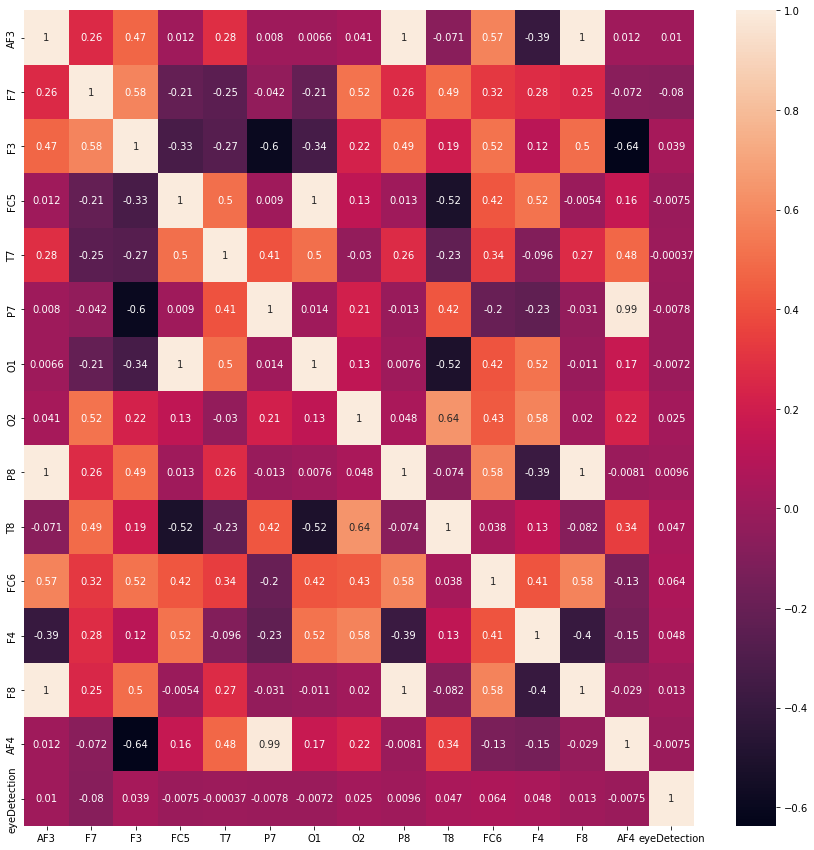

In [7]:
plt.figure(figsize = (15,15))
cor_matrix = df.corr()
sns.heatmap(cor_matrix,annot=True)

Text(0.5, 1.0, 'Target distribution')

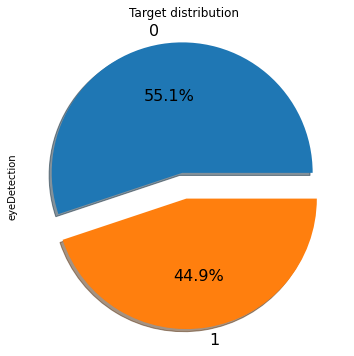

In [8]:
# Plotting target distribution 
plt.figure(figsize=(6,6))
df['eyeDetection'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

In [9]:
data = df.copy()
y= data.pop('eyeDetection')
x= data

In [10]:
x_new = StandardScaler().fit_transform(x)

In [11]:
x_new = pd.DataFrame(x_new) 
x_new.columns = x.columns

## Dividing into Training and Validation sets

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x_new,y,test_size=0.15)

In [13]:
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((12733, 14), (2247, 14), (12733,), (2247,))

## Reshaping the data as required by the model

In [14]:
x_train = np.array(x_train).reshape(-1,14,1)
x_test = np.array(x_test).reshape(-1,14,1)

In [15]:
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((12733, 14, 1), (2247, 14, 1), (12733,), (2247,))

## Defining the Model's architecture

In [16]:
inputs = tf.keras.Input(shape=(14,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)

#Dense2 = Dense(128, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(Dense1)
#Dense3 = Dense(256, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(Dense2)

lstm_1=  Bidirectional(LSTM(256, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3=  Bidirectional(LSTM(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)

flat = Flatten()(drop2)

#Dense_1 = Dense(256, activation = 'relu')(flat)

Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 dense (Dense)               (None, 14, 64)            128       
                                                                 
 bidirectional (Bidirectiona  (None, 14, 512)          657408    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 14, 256)          656384    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 256)           0     

In [17]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


The loss function used will be 'Binary CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.

In [18]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['binary_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=20,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model,history

## Analyzing the results.

### Confusion Matrix

In [19]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5, dtype = np.int)
confusion_matrix(y_test, y_pred)

71/71 [==============================] - 10s 69ms/step

array([[303, 925],
       [316, 703]], dtype=int64)

### Classification Report

In [20]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.49      0.25      0.33      1228
           1       0.43      0.69      0.53      1019

    accuracy                           0.45      2247
   macro avg       0.46      0.47      0.43      2247
weighted avg       0.46      0.45      0.42      2247



In [21]:
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 100) 

Epoch 1/100
637/637 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.5844     


KeyboardInterrupt



In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Analyzing the results

### Confusion Matrix

In [ ]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5, dtype = np.int)
confusion_matrix(y_test, y_pred)

### Classification Report

In [ ]:
print(classification_report(y_test, y_pred))